## Mount Google Drive


In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Set Project Directory and Change Path


In [ ]:
import os

project_dir = '/content/drive/MyDrive/Skin-Cancer-Detection'
os.chdir(project_dir)

## Copy Images and Metadata to Local Colab Disk


In [ ]:
import shutil

local_data_dir = '/content/data'
drive_data_dir = os.path.join(project_dir, 'data')

if not os.path.exists(f"{local_data_dir}/HAM10000"):
    os.makedirs(local_data_dir, exist_ok=True)
    print("Copying HAM10000 images to local disk...")
    shutil.copytree(os.path.join(drive_data_dir, 'HAM10000'),
                    f"{local_data_dir}/HAM10000")
else:
    print("HAM10000 images already copied.")

for fn in ['train_meta.csv', 'val_meta.csv', 'test_meta.csv']:
    src = os.path.join(drive_data_dir, fn)
    dst = os.path.join(local_data_dir, fn)
    if not os.path.exists(dst):
        shutil.copy(src, dst)
        print(f"Copied {fn} to local disk.")
    else:
        print(f"{fn} already exists in local disk.")

Copying HAM10000 images to local disk...
Copied train_meta.csv to local disk.
Copied val_meta.csv to local disk.
Copied test_meta.csv to local disk.


## Imports and Helper Functions


### Imports


In [ ]:
import albumentations as A
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import (EarlyStopping, ModelCheckpoint,
                                        ReduceLROnPlateau)
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import Sequence

### Helper Functions


In [ ]:
def gray_world(img, **kwargs):
    img = img.astype(np.float32)
    avgR, avgG, avgB = np.mean(img[:, :, 0]), np.mean(
        img[:, :, 1]), np.mean(img[:, :, 2])
    avgGray = (avgR + avgG + avgB) / 3
    img[:, :, 0] *= avgGray / (avgR + 1e-8)
    img[:, :, 1] *= avgGray / (avgG + 1e-8)
    img[:, :, 2] *= avgGray / (avgB + 1e-8)
    return np.clip(img, 0, 255).astype(np.uint8)


def get_train_aug(img_size=224):
    return A.Compose([
        A.Resize(img_size, img_size),
        A.Lambda(image=gray_world, p=0.6),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.Rotate(limit=90, p=0.5, border_mode=cv2.BORDER_REFLECT_101),
        A.Affine(
            scale=(0.98, 1.02),
            translate_percent={"x": (-0.06, 0.06), "y": (-0.06, 0.06)},
            shear=(-5, 5),
            border_mode=cv2.BORDER_REFLECT_101, p=0.35
        ),
        A.ColorJitter(brightness=0.12, contrast=0.12,
                      saturation=0.08, hue=0.03, p=0.45),
        A.RandomCrop(img_size, img_size, p=0.2),
        A.GaussNoise(std_range=(0.02, 0.08), mean_range=(0.0, 0.0),
                     per_channel=True, noise_scale_factor=1.0, p=0.12),
        A.CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=0.07),
    ])


def get_val_aug(img_size=224):
    return A.Compose([
        A.Resize(img_size, img_size),
    ])

## Custom Dataset Class


In [ ]:
class HAM10000Dataset(Sequence):
    def __init__(self, df, img_dir, img_size=224, augment_fn=None, batch_size=8, shuffle=True, label_encoder=None, **kwargs):
        super().__init__(**kwargs)
        self.df = df.reset_index(drop=True)
        self.img_dir = img_dir
        self.img_size = img_size
        self.augment_fn = augment_fn
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.label_encoder = label_encoder or LabelEncoder().fit(df['dx'])
        self.indices = np.arange(len(self.df))
        self.on_epoch_end()

    def __len__(self): return int(np.ceil(len(self.df) / self.batch_size))

    def __getitem__(self, idx):
        inds = self.indices[idx*self.batch_size:(idx+1)*self.batch_size]
        batch_df = self.df.iloc[inds]
        imgs, labels = [], []
        for _, row in batch_df.iterrows():
            img_path = f"{self.img_dir}/{row['image_id']}.jpg"
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            if self.augment_fn:
                img = self.augment_fn(image=img)['image']
            img = img.astype(np.float32) / 255.0
            imgs.append(np.array(img, dtype=np.float32))
            labels.append(row['dx'])
        X = np.stack(imgs).astype(np.float32)
        y = self.label_encoder.transform(labels)
        return X, y

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

## Load Splits and Compute Class Weights


In [ ]:
train_df = pd.read_csv("/content/data/train_meta.csv")
val_df = pd.read_csv("/content/data/val_meta.csv")

In [ ]:
label_encoder = LabelEncoder().fit(train_df['dx'])
classes = sorted(train_df['dx'].unique())
class_indices = {c: i for i, c in enumerate(classes)}

class_weights = compute_class_weight(
    class_weight='balanced', classes=np.array(classes), y=train_df['dx'])
class_weights_dict = {class_indices[c]: w for c, w in zip(classes, class_weights)}

### Define Custom Weighted Loss


In [ ]:
@tf.keras.utils.register_keras_serializable()
def weighted_loss(class_weights):
    weights = tf.constant([class_weights[i]
                          for i in range(len(class_weights))], dtype=tf.float32)

    def loss_fn(y_true, y_pred):
        y_true_int = tf.cast(y_true, tf.int32)
        sample_weights = tf.gather(weights, y_true_int)
        ce = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
        return tf.reduce_mean(ce * sample_weights)
    return loss_fn

## Model Configurations


In [ ]:
from tensorflow.keras.applications import (DenseNet201, EfficientNetB4,
                                           InceptionV3, ResNet101, Xception)



def build_model(backbone_fn, input_shape=(224, 224, 3), n_classes=7, pretrained='imagenet'):

    input_tensor = Input(shape=input_shape)

    base_model = backbone_fn(
        include_top=False, weights=pretrained, input_tensor=input_tensor)

    x = GlobalAveragePooling2D()(base_model.output)

    output = Dense(n_classes, activation="softmax")(x)

    return Model(inputs=input_tensor, outputs=output)

In [ ]:
all_models = {
    "efficientnetb4": {
        "fn": lambda: build_model(EfficientNetB4, input_shape=(380, 380, 3), n_classes=len(label_encoder.classes_)),
        "input_shape": (380, 380, 3),
        "img_size": 380,
        "batch_size": 4,
        "lr": 3e-5,
        "epochs": 80
    },
    "densenet201": {
        "fn": lambda: build_model(DenseNet201, input_shape=(224, 224, 3), n_classes=len(label_encoder.classes_)),
        "input_shape": (224, 224, 3),
        "img_size": 224,
        "batch_size": 8,
        "lr": 5e-5,
        "epochs": 100
    },
    "resnet101": {
        "fn": lambda: build_model(ResNet101, input_shape=(224, 224, 3), n_classes=len(label_encoder.classes_)),
        "input_shape": (224, 224, 3),
        "img_size": 224,
        "batch_size": 8,
        "lr": 1e-5,
        "epochs": 120
    },
    "inceptionv3": {
        "fn": lambda: build_model(InceptionV3, input_shape=(299, 299, 3), n_classes=len(label_encoder.classes_)),
        "input_shape": (299, 299, 3),
        "img_size": 299,
        "batch_size": 8,
        "lr": 3e-5,
        "epochs": 80
    },
    "xception": {
        "fn": lambda: build_model(Xception, input_shape=(299, 299, 3), n_classes=len(label_encoder.classes_)),
        "input_shape": (299, 299, 3),
        "img_size": 299,
        "batch_size": 8,
        "lr": 3e-5,
        "epochs": 80
    }
}

## Training Loop for All Models


In [ ]:
os.makedirs("/content/models", exist_ok=True)

In [ ]:
all_histories = {}

for name, mcfg in all_models.items():
    print(f"\n--- Training {name} ---")

    img_size = mcfg["img_size"]
    batch_size = mcfg["batch_size"]

    train_dataset = HAM10000Dataset(
        train_df, "/content/data/HAM10000",
        img_size=img_size,
        augment_fn=get_train_aug(img_size),
        batch_size=batch_size, shuffle=True, label_encoder=label_encoder
    )
    val_dataset = HAM10000Dataset(
        val_df, "/content/data/HAM10000",
        img_size=img_size,
        augment_fn=get_val_aug(img_size),
        batch_size=batch_size, shuffle=False, label_encoder=label_encoder
    )
    model = mcfg["fn"]()
    model.compile(
        optimizer=Adam(learning_rate=mcfg['lr']),
        loss=weighted_loss(class_weights_dict),
        metrics=["accuracy"]
    )
    callbacks = [
        ModelCheckpoint(f"/content/models/{name}_default.keras",
                        monitor="val_loss", mode="min", save_best_only=True, verbose=1),
        ReduceLROnPlateau(monitor="val_loss", factor=0.5,
                          patience=3, min_lr=1e-7, verbose=1),
        EarlyStopping(monitor="val_loss", patience=10,
                      verbose=1, restore_best_weights=True)
    ]
    history = model.fit(
        train_dataset,
        validation_data=val_dataset,
        epochs=mcfg["epochs"],
        callbacks=callbacks
    )

    all_histories[name] = history.history


--- Training efficientnetb4 ---
71686520/71686520 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Epoch 1/80
977/977 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.3298 - loss: 1.7612
Epoch 1: val_loss improved from inf to 1.26874, saving model to /content/models/efficientnetb4_best_model.keras
977/977 ━━━━━━━━━━━━━━━━━━━━ 304s 159ms/step - accuracy: 0.3299 - loss: 1.7610 - val_accuracy: 0.1809 - val_loss: 1.2687 - learning_rate: 3.0000e-05
Epoch 2/80
977/977 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.5139 - loss: 1.1497
Epoch 2: val_loss improved from 1.26874 to 1.21068, saving model to /content/models/efficientnetb4_best_model.keras
977/977 ━━━━━━━━━━━━━━━━━━━━ 86s 88ms/step - accuracy: 0.5139 - loss: 1.1496 - val_accuracy: 0.4375 - val_loss: 1.2107 - learning_rate: 3.0000e-05
Epoch 3/80
977/977 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.5744 - loss: 0.9692
Epoch 3: val_loss improved from 1.21068 to 1.16546, saving model to /content/models/efficientnetb4_best_model.keras
977/977 ━━━━━━

## Model Training Results


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import load_model
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import cv2
from tqdm import tqdm


def plot_model_history(history_dict, model_name="Model"):
    if isinstance(history_dict, dict):
        hist_df = pd.DataFrame(history_dict)
    else:
        hist_df = history_dict

    fig, axes = plt.subplots(1, 2, figsize=(14, 4))

    axes[0].plot(hist_df['loss'], label='Train Loss', linewidth=2)
    axes[0].plot(hist_df['val_loss'], label='Val Loss', linewidth=2)
    axes[0].set_title(f'{model_name} Loss Curve',
                      fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(alpha=0.3)

    axes[1].plot(hist_df['accuracy'], label='Train Acc', linewidth=2)
    axes[1].plot(hist_df['val_accuracy'], label='Val Acc', linewidth=2)
    axes[1].set_title(f'{model_name} Accuracy Curve',
                      fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    axes[1].grid(alpha=0.3)

    plt.suptitle(
        f"Training Results for {model_name}", fontsize=16, fontweight='bold')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

### EfficientNetB4 Metrics


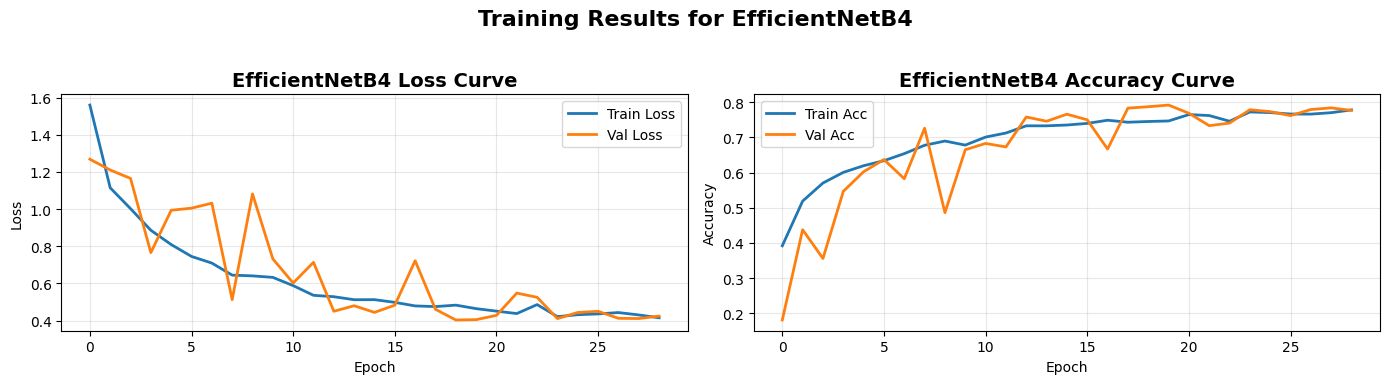

In [ ]:
plot_model_history(all_histories['efficientnetb4'],
                   model_name='EfficientNetB4')

### DenseNet201 Metrics


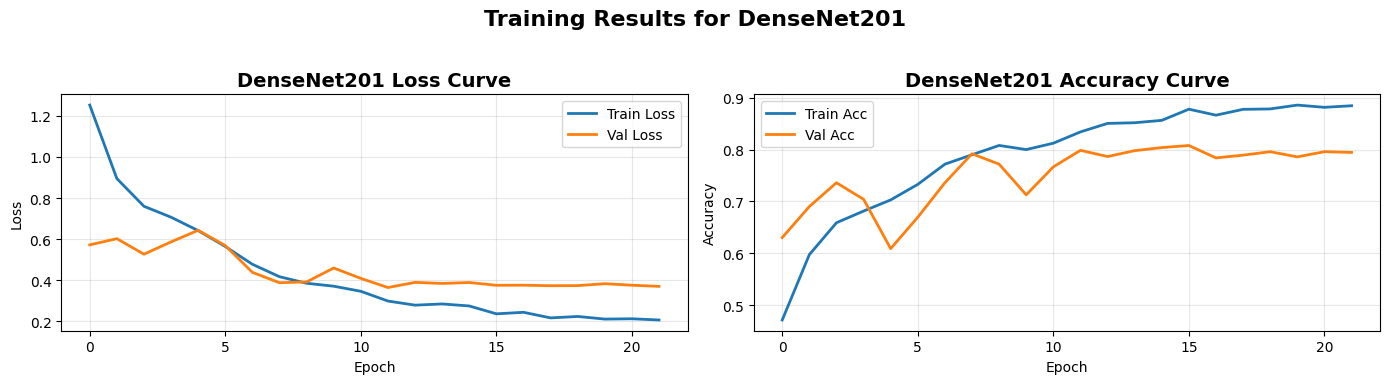

In [ ]:
plot_model_history(all_histories['densenet201'], model_name='DenseNet201')

### ResNet101 Metrics


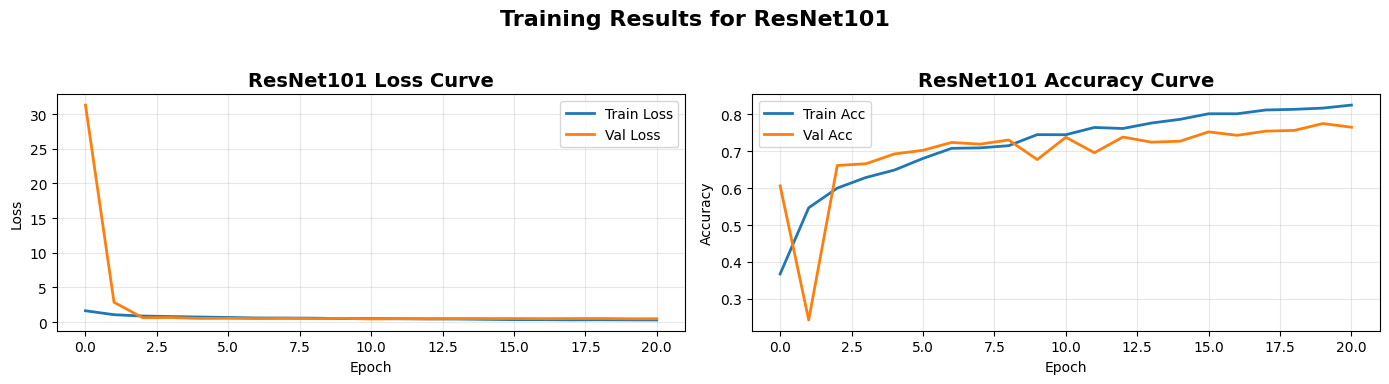

In [ ]:
plot_model_history(all_histories['resnet101'], model_name='ResNet101')

### InceptionV3 Metrics


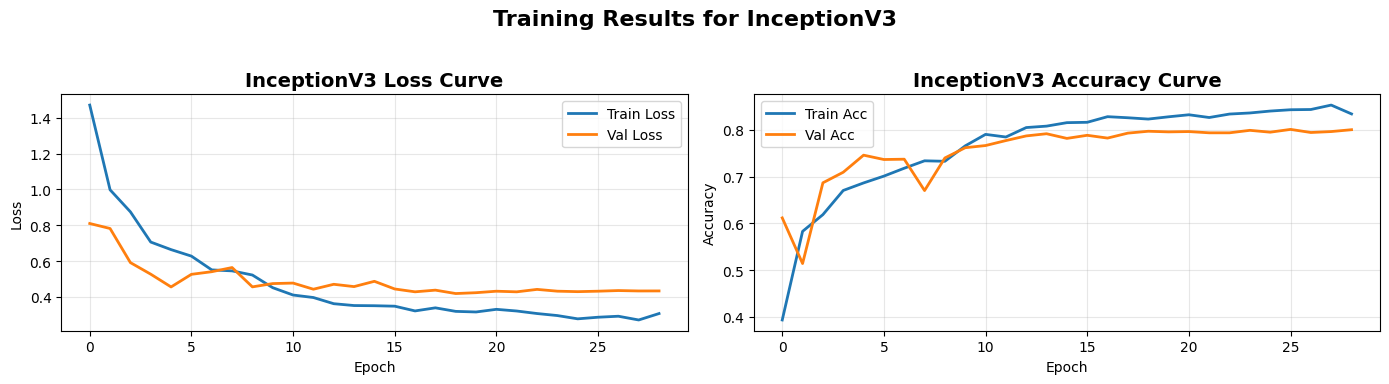

In [ ]:
plot_model_history(all_histories['inceptionv3'], model_name='InceptionV3')

### Xception Metrics


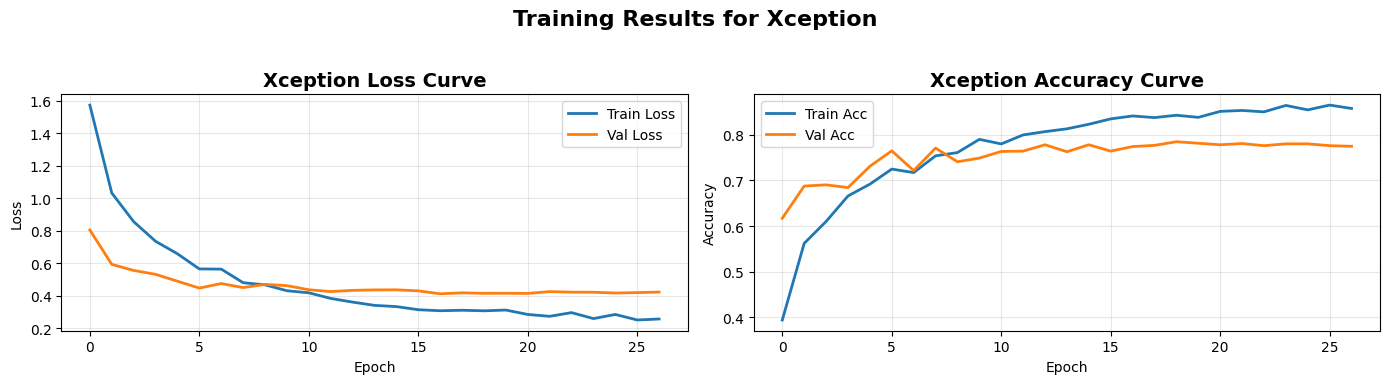

In [ ]:
plot_model_history(all_histories['xception'], model_name='Xception')

## Save All Trained Models from Colab Local to Google Drive


In [ ]:
import shutil

src_dir = '/content/models'
dst_dir = '/content/drive/MyDrive/Skin-Cancer-Detection/default'

os.makedirs(dst_dir, exist_ok=True)

for fname in os.listdir(src_dir):
    src_path = os.path.join(src_dir, fname)
    dst_path = os.path.join(dst_dir, fname)
    if os.path.isfile(src_path):
        shutil.copy2(src_path, dst_path)
        print(f"Copied {fname} to Google Drive.")

print("All models copied to Google Drive!")

Copied densenet201_best_model.keras to Google Drive.
Copied resnet101_best_model.keras to Google Drive.
Copied efficientnetb4_best_model.keras to Google Drive.
Copied inceptionv3_best_model.keras to Google Drive.
Copied xception_best_model.keras to Google Drive.
All models copied to Google Drive!


## Prepare Label Encoder and Class Labels


In [ ]:
test_df = pd.read_csv("/content/data/test_meta.csv")
label_encoder = LabelEncoder().fit(train_df['dx'])

## Evaluation Function


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, f1_score)

from tensorflow.keras.models import load_model



def evaluate_model(model_name, img_size, batch_size, model_path, test_df, label_encoder):

    print(f"Evaluating {model_name} ...")

    model = load_model(model_path, compile=False)


    test_dataset = HAM10000Dataset(

        test_df, "/content/data/HAM10000",

        img_size=img_size,

        augment_fn=get_val_aug(img_size),

        batch_size=batch_size,

        shuffle=False,
        label_encoder=label_encoder
    )


    preds_proba = model.predict(test_dataset, verbose=1)

    preds = np.argmax(preds_proba, axis=1)

    true_labels = label_encoder.transform(test_df['dx'])


    acc = accuracy_score(true_labels, preds)

    macro_f1 = f1_score(true_labels, preds, average='macro')


    print(f"Accuracy: {acc:.4f}")

    print(f"Macro F1: {macro_f1:.4f}")


    print("\nClassification Report:")

    print(classification_report(true_labels, preds,
          target_names=label_encoder.classes_))


    cm = confusion_matrix(true_labels, preds)

    plt.figure(figsize=(10, 8))

    sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_, cmap='Blues')

    plt.xlabel("Predicted")

    plt.ylabel("True")

    plt.title(f"Confusion Matrix: {model_name}")

    plt.show()

## Evaluate All Keras Models


### Evaluate EfficientNetB4


Evaluating EfficientNetB4 ...
373/373 ━━━━━━━━━━━━━━━━━━━━ 23s 34ms/step
Accuracy: 0.7520
Macro F1: 0.6101

Classification Report:
              precision    recall  f1-score   support

       akiec       0.49      0.73      0.59        45
         bcc       0.69      0.74      0.72        85
         bkl       0.51      0.62      0.56       153
          df       0.29      0.62      0.39        16
         mel       0.44      0.54      0.48       163
          nv       0.93      0.81      0.86      1009
        vasc       0.53      0.90      0.67        21

    accuracy                           0.75      1492
   macro avg       0.55      0.71      0.61      1492
weighted avg       0.79      0.75      0.77      1492



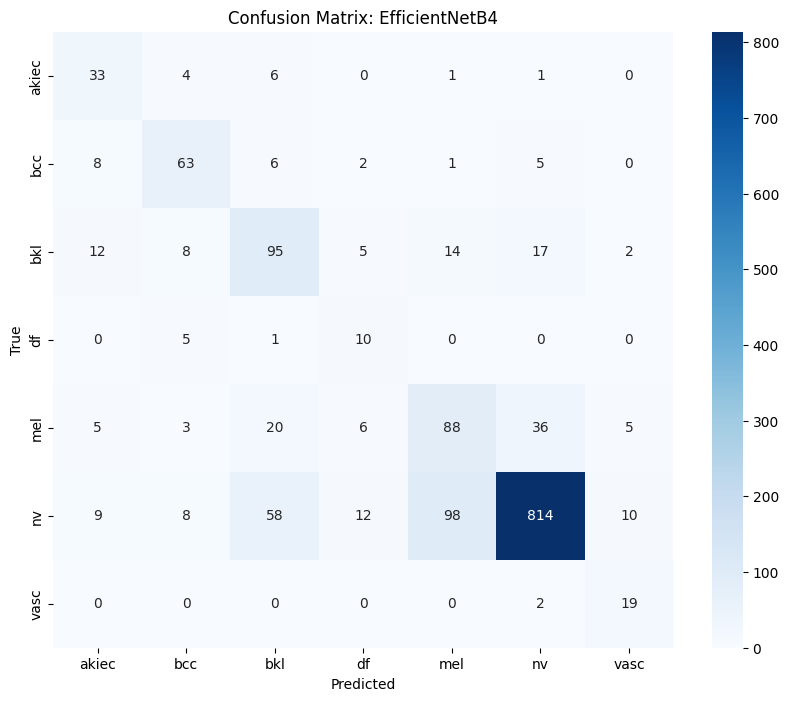

In [ ]:
evaluate_model("EfficientNetB4", 380, 4,
               "/content/drive/MyDrive/Skin-Cancer-Detection/default/efficientnetb4_default.keras", test_df, label_encoder)

### Evaluate DenseNet201


Evaluating DenseNet201 ...
187/187 ━━━━━━━━━━━━━━━━━━━━ 57s 192ms/step
Accuracy: 0.7735
Macro F1: 0.6224

Classification Report:
              precision    recall  f1-score   support

       akiec       0.46      0.67      0.55        45
         bcc       0.67      0.72      0.69        85
         bkl       0.56      0.62      0.59       153
          df       0.32      0.62      0.43        16
         mel       0.48      0.53      0.50       163
          nv       0.93      0.84      0.88      1009
        vasc       0.59      0.90      0.72        21

    accuracy                           0.77      1492
   macro avg       0.57      0.70      0.62      1492
weighted avg       0.80      0.77      0.78      1492



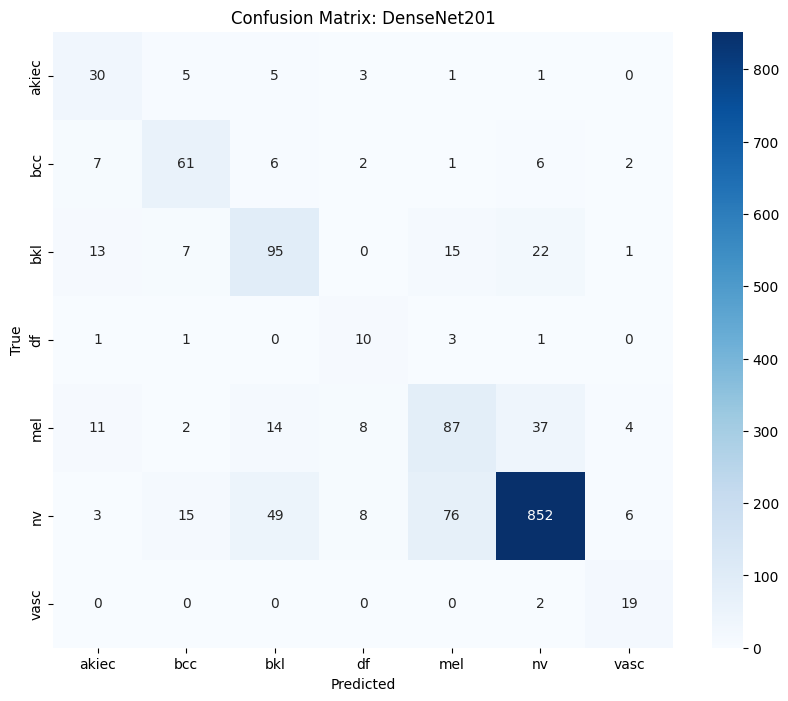

In [ ]:
evaluate_model("DenseNet201", 224, 8,
               "/content/drive/MyDrive/Skin-Cancer-Detection/default/densenet201_default.keras", test_df, label_encoder)

### Evaluate ResNet101


Evaluating ResNet101 ...
187/187 ━━━━━━━━━━━━━━━━━━━━ 26s 101ms/step
Accuracy: 0.7192
Macro F1: 0.5782

Classification Report:
              precision    recall  f1-score   support

       akiec       0.35      0.44      0.39        45
         bcc       0.56      0.73      0.64        85
         bkl       0.44      0.73      0.55       153
          df       0.34      0.62      0.44        16
         mel       0.42      0.53      0.47       163
          nv       0.95      0.76      0.84      1009
        vasc       0.59      0.90      0.72        21

    accuracy                           0.72      1492
   macro avg       0.52      0.67      0.58      1492
weighted avg       0.79      0.72      0.74      1492



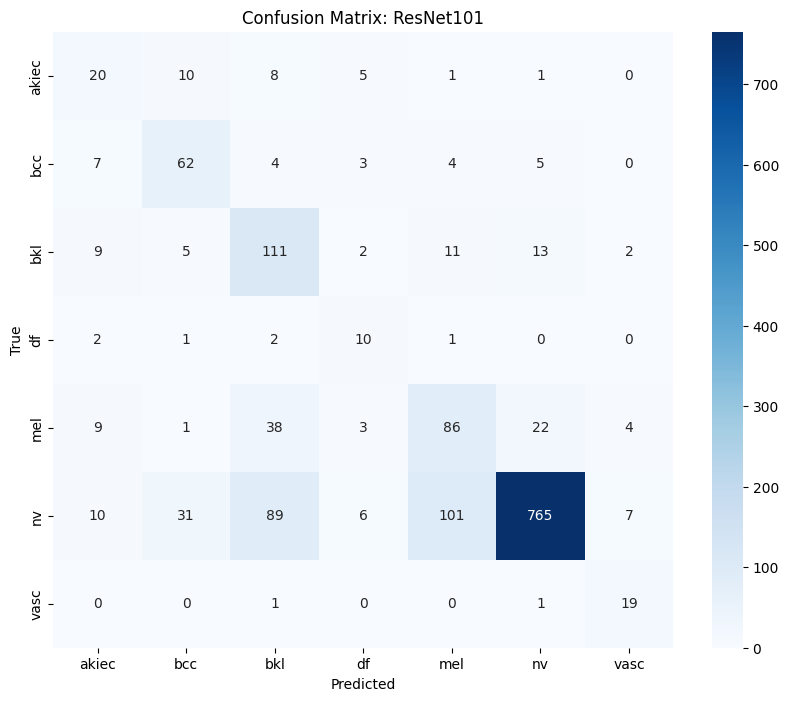

In [ ]:
evaluate_model("ResNet101", 224, 8,
               "/content/drive/MyDrive/Skin-Cancer-Detection/default/resnet101_default.keras", test_df, label_encoder)

### Evaluate InceptionV3


Evaluating InceptionV3 ...
187/187 ━━━━━━━━━━━━━━━━━━━━ 25s 104ms/step
Accuracy: 0.7735
Macro F1: 0.6459

Classification Report:
              precision    recall  f1-score   support

       akiec       0.51      0.58      0.54        45
         bcc       0.71      0.84      0.77        85
         bkl       0.50      0.60      0.54       153
          df       0.55      0.69      0.61        16
         mel       0.49      0.54      0.51       163
          nv       0.92      0.84      0.88      1009
        vasc       0.53      0.90      0.67        21

    accuracy                           0.77      1492
   macro avg       0.60      0.71      0.65      1492
weighted avg       0.80      0.77      0.78      1492



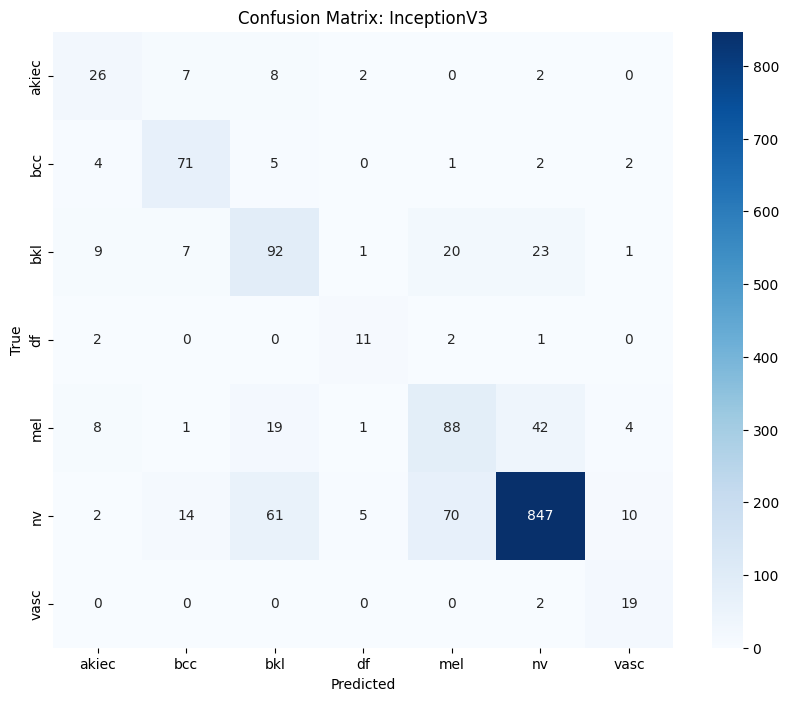

In [ ]:
evaluate_model("InceptionV3", 299, 8,
               "/content/drive/MyDrive/Skin-Cancer-Detection/default/inceptionv3_default.keras", test_df, label_encoder)

### Evaluate Xception


Evaluating Xception ...
187/187 ━━━━━━━━━━━━━━━━━━━━ 19s 86ms/step
Accuracy: 0.7594
Macro F1: 0.6359

Classification Report:
              precision    recall  f1-score   support

       akiec       0.49      0.69      0.57        45
         bcc       0.72      0.80      0.76        85
         bkl       0.50      0.70      0.59       153
          df       0.50      0.56      0.53        16
         mel       0.45      0.56      0.50       163
          nv       0.94      0.80      0.86      1009
        vasc       0.51      0.86      0.64        21

    accuracy                           0.76      1492
   macro avg       0.59      0.71      0.64      1492
weighted avg       0.80      0.76      0.77      1492



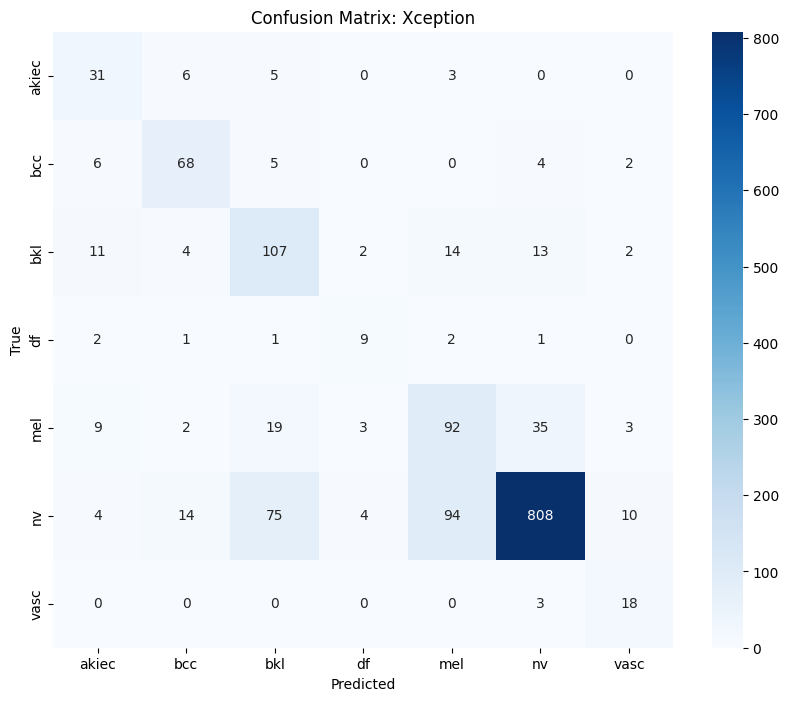

In [ ]:
evaluate_model("Xception", 299, 8,
               "/content/drive/MyDrive/Skin-Cancer-Detection/default/xception_default.keras", test_df, label_encoder)

## TTA Augmentations


In [ ]:
def get_tta_augmentations(img_size=224):
    return [
        A.Compose([A.Resize(img_size, img_size)]),
        A.Compose([A.HorizontalFlip(p=1.0), A.Resize(img_size, img_size)]),
        A.Compose([A.VerticalFlip(p=1.0), A.Resize(img_size, img_size)]),
        A.Compose([A.Rotate(limit=15, p=1.0, border_mode=cv2.BORDER_REFLECT_101), A.Resize(
            img_size, img_size)]),
    ]

## TTA Prediction Function


In [ ]:
def tta_predict(model, df, img_dir, img_size, label_encoder, tta_augs, batch_size=8):
    preds_list = []
    for aug in tta_augs:
        dataset = HAM10000Dataset(
            df, img_dir,
            img_size=img_size,
            augment_fn=aug,
            batch_size=batch_size,
            shuffle=False,
            label_encoder=label_encoder
        )
        preds = model.predict(dataset, verbose=1)
        preds_list.append(preds)
    avg_preds = np.mean(preds_list, axis=0)
    return avg_preds

## Define Evaluation Function with TTA Support


In [ ]:
def evaluate_model_tta(model_name, img_size, batch_size, model_path, test_df, label_encoder):
    print(f"Evaluating {model_name} with TTA ...")
    model = load_model(model_path, compile=False)

    tta_augs = get_tta_augmentations(img_size)
    preds_proba = tta_predict(model, test_df, "/content/data/HAM10000",
                              img_size, label_encoder, tta_augs, batch_size=batch_size)
    preds = np.argmax(preds_proba, axis=1)
    true_labels = label_encoder.transform(test_df['dx'])

    acc = accuracy_score(true_labels, preds)
    macro_f1 = f1_score(true_labels, preds, average='macro')

    print(f"TTA Accuracy: {acc:.4f}")
    print(f"TTA Macro F1: {macro_f1:.4f}")

    print("\nClassification Report:")
    print(classification_report(true_labels, preds,
          target_names=label_encoder.classes_))

    cm = confusion_matrix(true_labels, preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_, cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix with TTA: {model_name}")
    plt.show()

### TTA Evaluation for EfficientNetB4


Evaluating EfficientNetB4 with TTA ...
373/373 ━━━━━━━━━━━━━━━━━━━━ 23s 33ms/step
373/373 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step
373/373 ━━━━━━━━━━━━━━━━━━━━ 13s 34ms/step
373/373 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step
TTA Accuracy: 0.7701
TTA Macro F1: 0.6470

Classification Report:
              precision    recall  f1-score   support

       akiec       0.56      0.80      0.66        45
         bcc       0.75      0.82      0.79        85
         bkl       0.53      0.61      0.57       153
          df       0.37      0.69      0.48        16
         mel       0.46      0.56      0.51       163
          nv       0.93      0.82      0.87      1009
        vasc       0.51      0.90      0.66        21

    accuracy                           0.77      1492
   macro avg       0.59      0.74      0.65      1492
weighted avg       0.80      0.77      0.78      1492



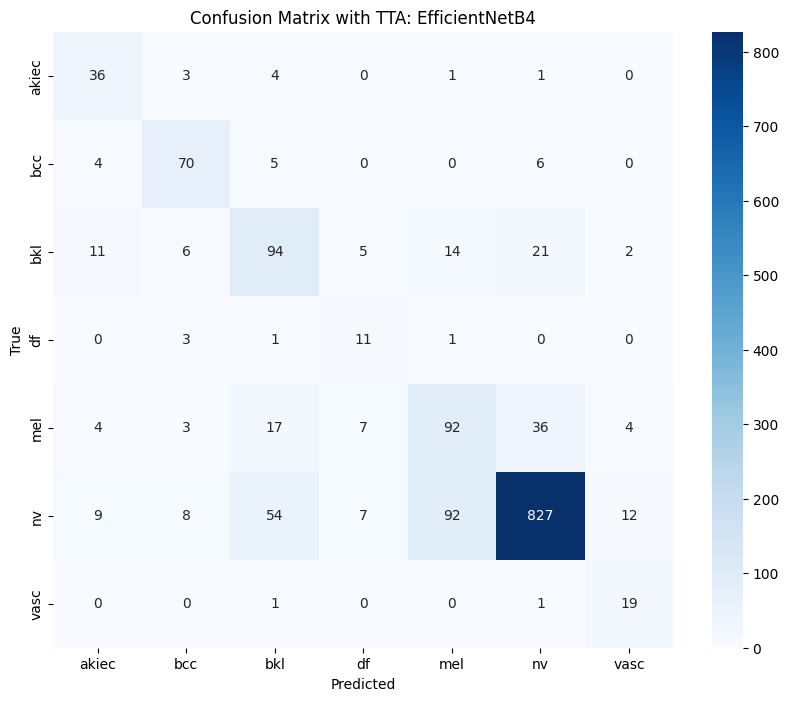

In [ ]:
evaluate_model_tta(
    model_name="EfficientNetB4",
    img_size=380,
    batch_size=4,
    model_path="/content/drive/MyDrive/Skin-Cancer-Detection/default/efficientnetb4_default.keras",
    test_df=test_df,
    label_encoder=label_encoder
)

### TTA Evaluation for DenseNet201


Evaluating DenseNet201 with TTA ...
187/187 ━━━━━━━━━━━━━━━━━━━━ 49s 157ms/step
187/187 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step
187/187 ━━━━━━━━━━━━━━━━━━━━ 10s 55ms/step
187/187 ━━━━━━━━━━━━━━━━━━━━ 12s 66ms/step
TTA Accuracy: 0.7862
TTA Macro F1: 0.6422

Classification Report:
              precision    recall  f1-score   support

       akiec       0.46      0.73      0.57        45
         bcc       0.69      0.72      0.71        85
         bkl       0.59      0.63      0.61       153
          df       0.36      0.62      0.45        16
         mel       0.51      0.57      0.54       163
          nv       0.93      0.85      0.89      1009
        vasc       0.61      0.90      0.73        21

    accuracy                           0.79      1492
   macro avg       0.59      0.72      0.64      1492
weighted avg       0.81      0.79      0.79      1492



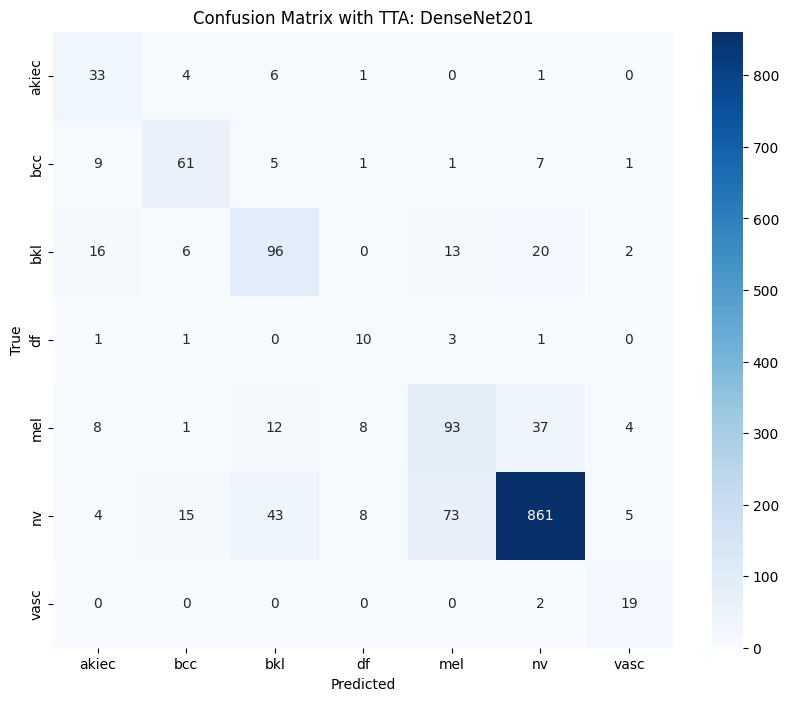

In [ ]:
evaluate_model_tta(
    model_name="DenseNet201",
    img_size=224,
    batch_size=8,
    model_path="/content/drive/MyDrive/Skin-Cancer-Detection/default/densenet201_default.keras",
    test_df=test_df,
    label_encoder=label_encoder
)

### TTA Evaluation for ResNet101


Evaluating ResNet101 with TTA ...
187/187 ━━━━━━━━━━━━━━━━━━━━ 24s 90ms/step
187/187 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step
187/187 ━━━━━━━━━━━━━━━━━━━━ 10s 54ms/step
187/187 ━━━━━━━━━━━━━━━━━━━━ 12s 65ms/step
TTA Accuracy: 0.7292
TTA Macro F1: 0.5848

Classification Report:
              precision    recall  f1-score   support

       akiec       0.38      0.44      0.41        45
         bcc       0.56      0.72      0.63        85
         bkl       0.46      0.74      0.56       153
          df       0.34      0.62      0.44        16
         mel       0.45      0.58      0.51       163
          nv       0.95      0.76      0.85      1009
        vasc       0.56      0.90      0.69        21

    accuracy                           0.73      1492
   macro avg       0.53      0.68      0.58      1492
weighted avg       0.79      0.73      0.75      1492



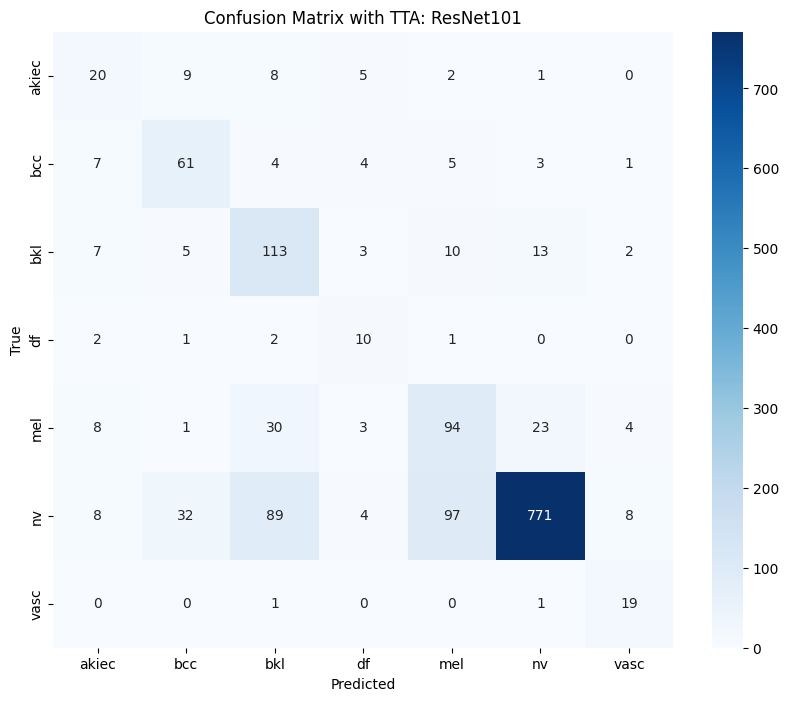

In [ ]:
evaluate_model_tta(
    model_name="ResNet101",
    img_size=224,
    batch_size=8,
    model_path="/content/drive/MyDrive/Skin-Cancer-Detection/default/resnet101_default.keras",
    test_df=test_df,
    label_encoder=label_encoder
)

### TTA Evaluation for InceptionV3


Evaluating InceptionV3 with TTA ...
187/187 ━━━━━━━━━━━━━━━━━━━━ 22s 88ms/step
187/187 ━━━━━━━━━━━━━━━━━━━━ 11s 60ms/step
187/187 ━━━━━━━━━━━━━━━━━━━━ 11s 60ms/step
187/187 ━━━━━━━━━━━━━━━━━━━━ 13s 70ms/step
TTA Accuracy: 0.7942
TTA Macro F1: 0.6831

Classification Report:
              precision    recall  f1-score   support

       akiec       0.55      0.62      0.58        45
         bcc       0.72      0.88      0.79        85
         bkl       0.54      0.67      0.60       153
          df       0.73      0.69      0.71        16
         mel       0.53      0.55      0.54       163
          nv       0.93      0.85      0.89      1009
        vasc       0.55      0.86      0.67        21

    accuracy                           0.79      1492
   macro avg       0.65      0.73      0.68      1492
weighted avg       0.81      0.79      0.80      1492



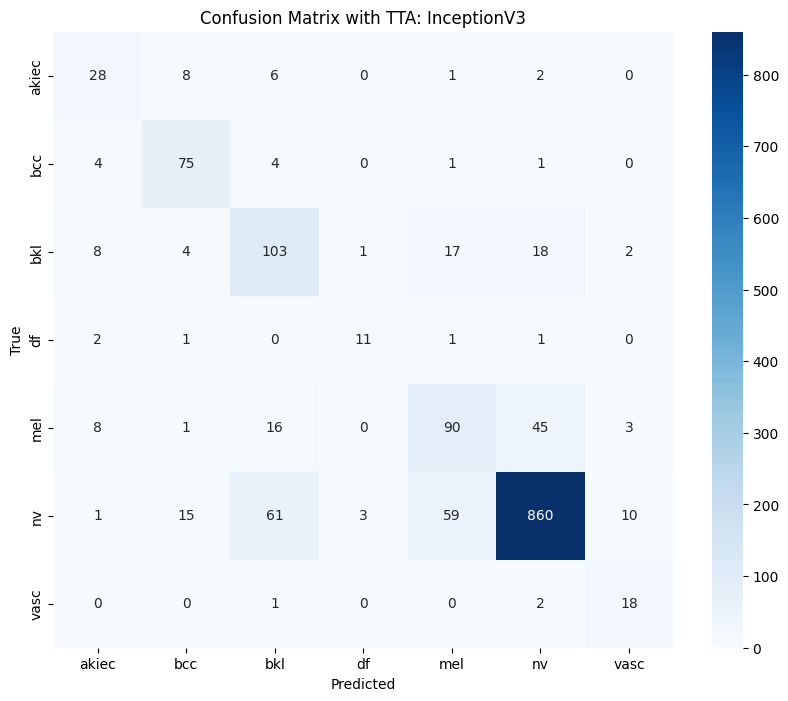

In [ ]:
evaluate_model_tta(
    model_name="InceptionV3",
    img_size=299,
    batch_size=8,
    model_path="/content/drive/MyDrive/Skin-Cancer-Detection/default/inceptionv3_default.keras",
    test_df=test_df,
    label_encoder=label_encoder
)

### TTA Evaluation for Xception


Evaluating Xception with TTA ...
187/187 ━━━━━━━━━━━━━━━━━━━━ 17s 73ms/step
187/187 ━━━━━━━━━━━━━━━━━━━━ 11s 59ms/step
187/187 ━━━━━━━━━━━━━━━━━━━━ 11s 59ms/step
187/187 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step
TTA Accuracy: 0.7661
TTA Macro F1: 0.6397

Classification Report:
              precision    recall  f1-score   support

       akiec       0.53      0.69      0.60        45
         bcc       0.71      0.84      0.77        85
         bkl       0.52      0.71      0.60       153
          df       0.50      0.56      0.53        16
         mel       0.44      0.52      0.48       163
          nv       0.93      0.81      0.87      1009
        vasc       0.50      0.86      0.63        21

    accuracy                           0.77      1492
   macro avg       0.59      0.71      0.64      1492
weighted avg       0.80      0.77      0.78      1492



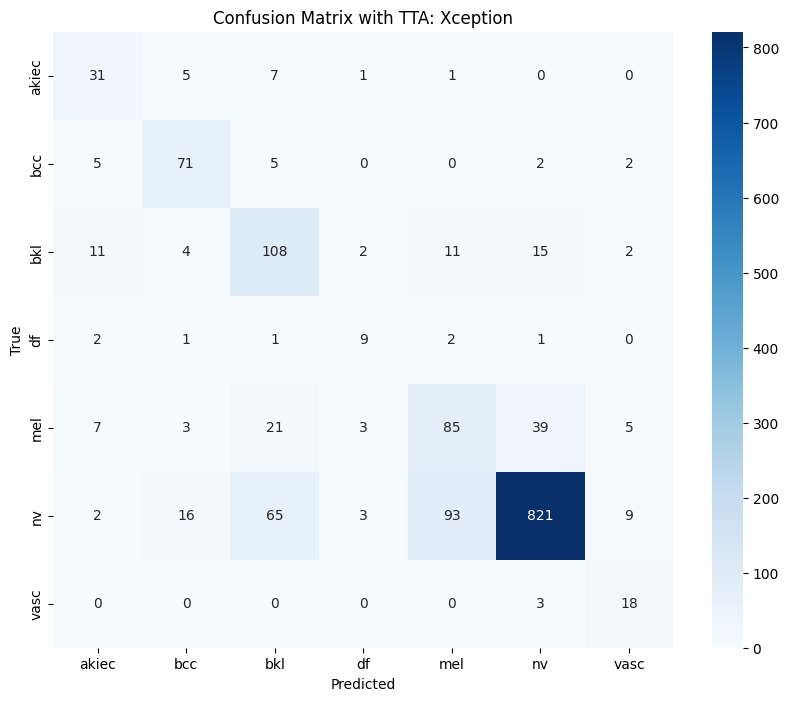

In [ ]:
evaluate_model_tta(
    model_name="Xception",
    img_size=299,
    batch_size=8,
    model_path="/content/drive/MyDrive/Skin-Cancer-Detection/default/xception_default.keras",
    test_df=test_df,
    label_encoder=label_encoder
)